This ipython notebook demonstrates how to calculate photometric (optimal psf-weighted) SNR for sources observed with LSST. 

It uses the [rubin_sim.photUtils](https://github.com/lsst/rubin_sim) package, to calculate the SNR for any spectrum. Baseline LSST throughput curves come with the `rubin_sim` package, in `rubin_sim_data`.

An overview of the process (starting from the spectrum) is:
* Set the desired magnitude (in a standardized throughput curve) for the source - this sets the SED normalization.
* Generate throughput curves in all filters, for the airmass desired.
* Set the sky SED (for now we just use a dark, zenith sky SED, but can scale the overall sky brightness up or down).
* Calculate the SNR. 


In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from rubin_sim.photUtils import Bandpass
from rubin_sim.photUtils import Sed
from rubin_sim.photUtils import SignalToNoise
from rubin_sim.photUtils import PhotometricParameters
from rubin_sim.photUtils import calcNeff

from rubin_sim.site_models import SeeingModel
from rubin_sim.data import get_data_dir

-----

###  Read some useful data ###

<b>Read some sample spectra.</b> 

The repo [photometry_sample](https://github.com/rhiannonlynne/photometry_sample) contains a few SEDs that cover a fairly wide range: elliptical and spiral galaxies, blue to red stars, white dwarfs, sn, and a quasar. We'll read a subset of them into `Sed` objects, and redshift the quasar. 

Clone the repo, then set `sedDir` to whereever you place the directory.

In [2]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies', 'quasar', 'stars'] 
sedtypes_not_used = ['sn', 'photoZ_outliers', 'white_dwarf']
sedtypes = sedtypes + sedtypes_not_used

seds = {}
for s in sedtypes:
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        seds[name] = Sed()
        seds[name].readSED_flambda(os.path.join(sedDir, s, f))
list(seds.keys())

['Sa_template_norm',
 'Sdm_template_norm0',
 'Ell2_template_norm',
 'quasar',
 'km10_5250.fits_g45',
 'km10_4500.fits_g45',
 'm3.0Full',
 'km10_6000.fits_g45',
 'km10_7250.fits_g45',
 'km10_6500.fits_g45',
 'sn1a_10.0',
 'sn1a_15.0',
 'sn1a_20.0',
 'xspec_173',
 'xspec_172',
 'xspec_90',
 'xspec_91',
 'xspec_176',
 'xspec_175',
 'wd_He_5500_80',
 'wd_H_5500_80',
 'wd_He_15000_80',
 'wd_H_50000_80',
 'wd_He_10000_80',
 'wd_H_100000_80',
 'wd_H_15000_80']

In [3]:
# Redshift the quasar. Note repeat calls to this cell will stack, increasing the redshift multiple times.
z=1.5
seds['quasar'].redshiftSED(z)

Text(0, 0.5, 'Wavelength * Flambda')

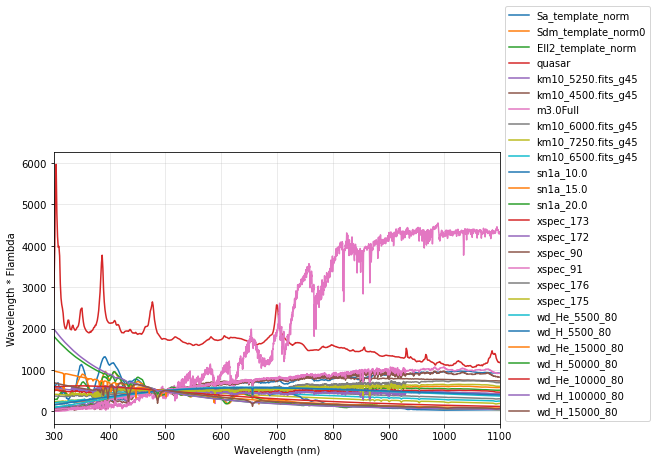

In [4]:
# Plot the seds
plt.figure(figsize=(8,5))
for n in seds:
    plt.plot(seds[n].wavelen, seds[n].flambda * seds[n].wavelen, label=n)
plt.legend(loc=(1.01, 0.01))
plt.xlim(300, 1100)
plt.grid(alpha=0.3)
plt.xlabel('Wavelength (nm)')
plt.ylabel("Wavelength * Flambda")

<b>Read the standard throughput components, a range of atmospheres, and a sky background spectra</b>.

These are provided as part of `rubin_sim_data`, in the `throughputs` directory. 

In [5]:
throughputsDir = os.path.join(get_data_dir(), 'throughputs')

!ls -l $throughputsDir

filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
filtercolors = {'u':'c', 'g':'g', 'r':'y', 'i':'r', 'z':'m', 'y':'k'}

total 8
drwxr-xr-x   5 dagoret  staff   160 May  7  2021 2MASS
-rw-r--r--   1 dagoret  staff  1098 May  7  2021 README.md
drwxr-xr-x   6 dagoret  staff   192 May  7  2021 WISE
drwxr-xr-x   9 dagoret  staff   288 Aug  4  2021 approximate_baseline
drwxr-xr-x  39 dagoret  staff  1248 May  7  2021 atmos
drwxr-xr-x  33 dagoret  staff  1056 Aug  4  2021 baseline
drwxr-xr-x   3 dagoret  staff    96 May  7  2021 hipparcos
drwxr-xr-x   5 dagoret  staff   160 May  7  2021 imsim
drwxr-xr-x   5 dagoret  staff   160 May  7  2021 johnson
drwxr-xr-x  10 dagoret  staff   320 May  7  2021 megacam
drwxr-xr-x   7 dagoret  staff   224 May  7  2021 panStarrs
drwxr-xr-x  15 dagoret  staff   480 May  7  2021 sdss
drwxr-xr-x   4 dagoret  staff   128 May  7  2021 tycho


Read in the set of throughput curves we'll use as our "standard". These are the 'standard' LSST total throughput curves and use an X=1.2 atmosphere (with aerosols) together with the standard hardware components (with time-average losses). 

In [6]:
lsst_std = {}
for f in filterlist:
    lsst_std[f] = Bandpass()
    lsst_std[f].readThroughput(os.path.join(throughputsDir, 'baseline', f'total_{f}.dat'))

Text(0.5, 1.0, 'Standard throughput curves (X=1.2)')

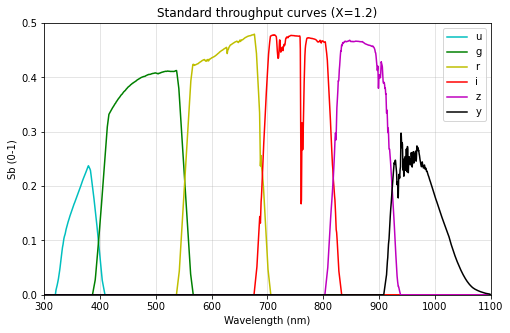

In [7]:
# Plot the filters 

plt.figure(figsize=(8,5))
for f in filterlist:
    plt.plot(lsst_std[f].wavelen, lsst_std[f].sb, color=filtercolors[f], label=f)
plt.legend()
plt.ylim(0, 0.5)
plt.xlim(300, 1100)
plt.grid(alpha=0.4)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Sb (0-1)")
plt.title("Standard throughput curves (X=1.2)")

Read in the zenith, dark sky spectrum. This is the only sky background spectrum we have available at this time .. obviously it's not the right colors for other lunar phases, as a function of distance from the moon, or even necessarily at different airmasses. However, as a placeholder, we can scale it up and down to match a specified sky background magnitude in a different bandpass. 

In [8]:
darksky = Sed()
darksky.readSED_flambda(os.path.join(throughputsDir, 'baseline', 'darksky.dat'))

Read in the hardware components of the throughput curves. 
The hardware-only is used to calculate sky brightness values, as atmospheric extinction should not be applied to sky brightness. 
It's also useful to combine with other atmospheres, to estimate the effect of atmospheric extinction at different airmass. 

In [9]:
lsst_hardware = {}
for f in filterlist:
    lsst_hardware[f] = Bandpass()
    lsst_hardware[f].readThroughputList(['detector.dat', 'lens1.dat', 'lens2.dat', 'lens3.dat', 
                                        'm1.dat', 'm2.dat', 'm3.dat', f'filter_{f}.dat'], 
                                        rootDir=os.path.join(throughputsDir, 'baseline'))

Read in a series of atmospheres with different airmasses. This doesn't include varying atmospheric extinction as e.g. water vapor percentage changes, but it does include a range of atmospheric extinction with the same atmospheric composition. 

In [10]:
airmass_range = np.arange(1, 2.55, 0.1)

atmosphere = {}
for X in airmass_range:
    atmosphere[X] = Bandpass()
    atmosphere[X].readThroughput(os.path.join(throughputsDir, 'atmos', f'atmos_{int(X*10)}_aerosol.dat'))

---

### Define useful functions ###

Define some functions useful for calculating SNR:
* return a spectra scaled to a specified magnitude in a specified filter (in a standard/reference bandpass)
* return a sky spectra scaled to a specified magnitude in a specified filter
* return the approximate throughput curves at a specified airmass
* convert seeing to the expected FWHM_eff at the specified airmass

In [11]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calcFluxNorm(ref_mag, lsst_std[ref_filter])
    sed.multiplyFluxNorm(fluxNorm)
    return sed


def scale_sky(sky_mag, sky_filter, skysed=None):
    if skysed is None:
        skysed = copy.deepcopy(darksky)
    fluxNorm = skysed.calcFluxNorm(sky_mag, lsst_hardware[sky_filter])
    skysed.multiplyFluxNorm(fluxNorm)
    return skysed


def throughput_at_X(airmass):
    diff = np.abs(airmass - airmass_range)
    idx = np.where(diff == diff.min())[0]
    X = airmass_range[idx][0]
    lsst_x = {}
    for f in filterlist:
        wavelen, sb = lsst_hardware[f].multiplyThroughputs(atmosphere[X].wavelen, atmosphere[X].sb)
        lsst_x[f] = Bandpass(wavelen=wavelen, sb=sb)
    return lsst_x


seeing_model = SeeingModel()
def seeing_at_X(obs_filter, obs_X, atmospheric_seeing_500nm=None, seeing_zenith=None):
    "Return FWHMeff in `obs_filter` at `obs_X`, providing either the seeing @ zenith (in filter) or the FWHM_500"
    if atmospheric_seeing_500nm is not None:
        idx = filterlist.index(obs_filter)
        fwhm_eff = seeing_model(atmospheric_seeing_500nm, obs_X)['fwhmEff'][idx]
    elif seeing_zenith is not None:
        # assume seeing_zenith is in the filter of choice and just approximate for airmass 
        airmass_correction = np.power(obs_X, 0.6)
        fwhm_eff = 1.16 * seeing_zenith * airmass_correction
    else:
        raise ValueErorr('Must specify atmospheric_seeing_500nm or seeing_zenith')
    return fwhm_eff


def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams


def calc_snr(sed, obs_filter, obs_skymag, obs_fwhm_eff, obs_X, 
             ref_filter, ref_mag, 
             exptime=15, nexp=2, verbose=False):
    obs_sky = scale_sky(obs_skymag, obs_filter)
    lsst_x = throughput_at_X(obs_X)
    scaled_sed = scale_sed(ref_mag, ref_filter, sed)
    photParams = set_photometric_parameters(exptime, nexp)
    snr = SignalToNoise.calcSNR_sed(scaled_sed, lsst_x[obs_filter], 
                                    obs_sky, lsst_hardware[obs_filter], 
                                    photParams, FWHMeff=obs_fwhm_eff, 
                                    verbose=verbose)
    return snr

---

### Calculate SNR ###


The SNR of a source depends on the sky background, seeing, and airmass, as well as the sensitivity of the telescope and camera. Calculation of SNR is described in [SMTN-002](https://smtn-002.lsst.io), and the typical sky, seeing, airmass, and throughput sensitivities are described in more detail in [PSTN-054](https://pstn-054.lsst.io). 

We can put these together with `rubin_sim` to estimate SNR for a given source at a given airmass, seeing, and skybackground. Some helpful functions have been defined above, as well as some helpful or required data. 

For the sky background, we currently do not have a variety of lunar phase sky background SEDs to use; so we'll approximate it by using our "zenith dark sky" SED and just scaling it to have the expected magnitude in the given bandpass. Because we don't have a bandpass-spanning sky SED, the calculations below should be calculated a single bandpass at a time, rescaling the sky SED for each filter/skybrightness value. 

In [12]:
# Specify filter for observing, airmass, and expected skybrightness.
# The seeing can be specified as either the atmospheric contribution at zenith at 500nm ("FWHM_500")
#  or it can be specified as the expected seeing fwhm_eff at zenith, in the specified bandpass.

obs_filter = 'i'
obs_X = 1.5
obs_skybrightness = 19.8 # magnitudes per sq arcsecond 
fwhm_500 = 0.72

obs_fwhmeff = seeing_at_X(obs_filter, obs_X, atmospheric_seeing_500nm=fwhm_500)

For this illustration, we'll calculate the SNR for all of our sample SEDs above. You could also just pop in your own SED.

In [13]:
# Specify the brightness expected for the source, in a reference (standard) filter 
# (this does not have to be the same as obs_filter)
ref_mag = 24.0
ref_filter = 'r'

snr = {}
for s in seds:
    seds[s] = scale_sed(ref_mag, ref_filter, seds[s])
    snr[s] = calc_snr(seds[s], obs_filter, obs_skybrightness, obs_fwhmeff, obs_X, 
                      ref_filter, ref_mag, 
                      exptime=15, nexp=2)

pd.DataFrame(snr, index=[f'SNR {obs_filter} for sed with {ref_mag} mag in {ref_filter}']).T

,SNR i for sed with 24.0 mag in r
Sa_template_norm,3.344975
Sdm_template_norm0,3.004399
Ell2_template_norm,2.938435
quasar,2.857899
km10_5250.fits_g45,2.909962
km10_4500.fits_g45,3.261207
m3.0Full,7.459374
km10_6000.fits_g45,2.691123
km10_7250.fits_g45,2.397845
km10_6500.fits_g45,2.567145


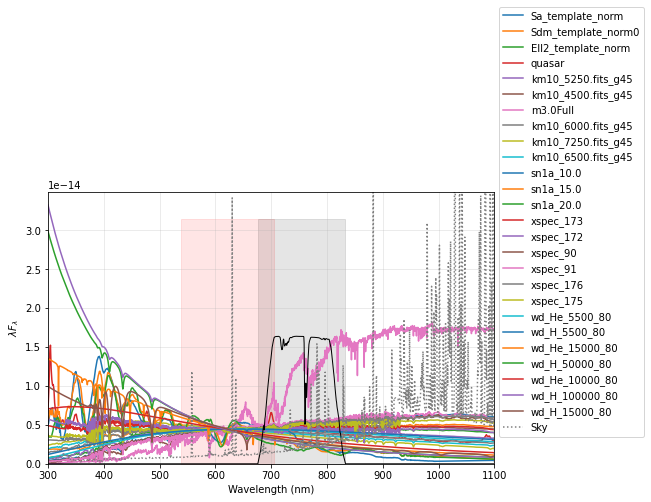

In [14]:
obs_sky = scale_sky(obs_skybrightness, obs_filter)
lsst_x = throughput_at_X(obs_X)

# A plot for illustration - normalized SED, reference bandpass range, and observing bandpass
plt.figure(figsize=(8,5))
for s in seds:
    plt.plot(seds[s].wavelen, seds[s].flambda*seds[s].wavelen, label=s)
ymax = plt.ylim()[1]
# show ref filter range with a simple definition of 'in_band'
in_band = np.where(lsst_std[ref_filter].sb > 0.01)
plt.fill_betweenx(np.arange(0, ymax, ymax/10), 
                  x1=lsst_std[ref_filter].wavelen[in_band].min(),
                  x2=lsst_std[ref_filter].wavelen[in_band].max(),
                  alpha=0.1, color='r')
# show obs filter 
plt.plot(lsst_x[obs_filter].wavelen, lsst_x[obs_filter].sb * (ymax),#/lsst_x[obs_filter].sb.max()), 
         color='k', linewidth=1,)
in_band = np.where(lsst_x[obs_filter].sb > 0.01)
plt.fill_betweenx(np.arange(0, ymax, ymax/10), 
                  x1=lsst_x[obs_filter].wavelen[in_band].min(),
                  x2=lsst_x[obs_filter].wavelen[in_band].max(),
                  alpha=0.1, color='k')
# show sky
skyscale = calcNeff(obs_fwhmeff, set_photometric_parameters(15, 2).platescale)
plt.plot(obs_sky.wavelen, 
         (obs_sky.flambda * obs_sky.wavelen)/skyscale, 
         label='Sky', color='gray', linestyle=':')
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\lambda F_\lambda$')
plt.xlim(300, 1100)
plt.ylim(0, ymax)
plt.legend(loc=(1.01, 0.1), fancybox=True)
plt.grid(alpha=0.3)

----

In [15]:
# We can investigate the SNR calculation a little closer for a single object, let's use one of the stars.

s = 'km10_7250.fits_g45'

ref_mag = 23.0
ref_filter = 'r'
obs_filter = 'i'
obs_X = 1.5
obs_skybrightness = 20.48 # magnitudes per sq arcsecond 
fwhm_500 = 0.5

obs_fwhmeff = seeing_at_X(obs_filter, obs_X, atmospheric_seeing_500nm=fwhm_500)

snr[s] = calc_snr(seds[s], obs_filter, obs_skybrightness, obs_fwhmeff, obs_X, 
                  ref_filter, ref_mag, exptime=15, nexp=2, verbose=True)


For Nexp 2.0 of time 15.0: 
Counts from source: 1080.12  Counts from sky: 509.00
FWHMeff: 0.89('')  Neff pixels: 44.897(pix)
Noise from sky: 14.88 Noise from instrument: 5.51
Noise from source: 21.67
 Total Signal: 1080.12   Total Noise: 108.49    SNR: 9.96


----

In [16]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_mags = {}
for f in filterlist:
    darksky_mags[f] = darksky.calcMag(lsst_hardware[f])
pd.DataFrame(darksky_mags, index=['Dark sky magnitudes']).round(2)

,u,g,r,i,z,y
Dark sky magnitudes,22.96,22.26,21.2,20.48,19.6,18.61
